# testing json files

Plotting data from ../data/seaice_geojson/2000.json for date: 2000-01...
Displaying plot...


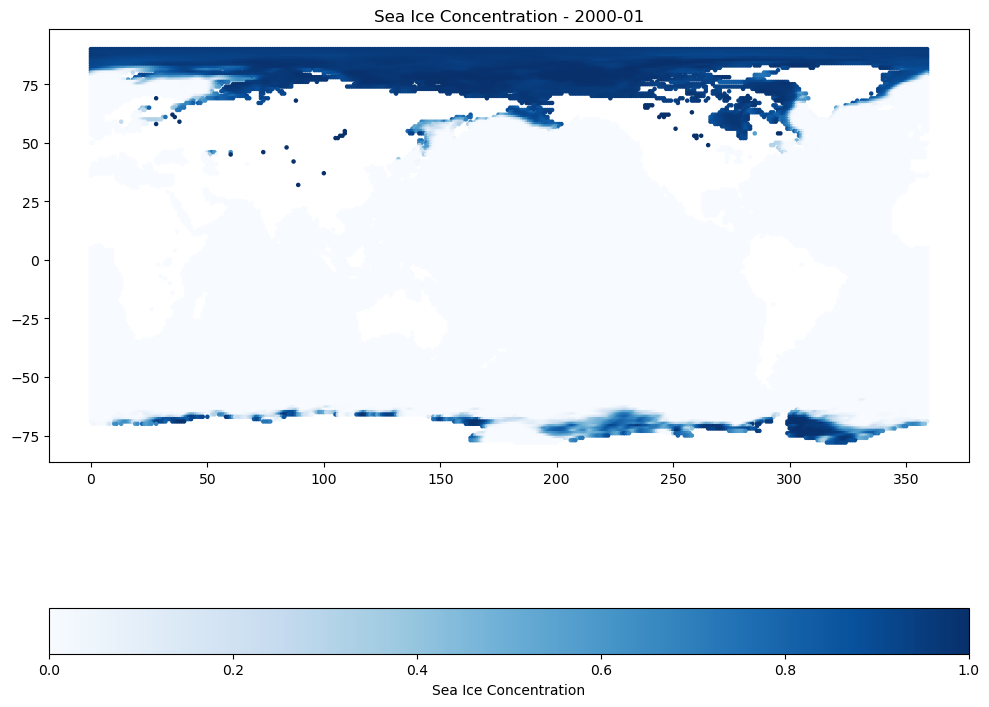

Plotting complete.


In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import json # Import the json library to load the date

# --- Configuration ---
# Define the path to the GeoJSON file
# You can change this to plot data from a different year/month
geojson_file_path = '../data/seaice_geojson/2000.json'

# --- Data Loading ---
try:
    # Read the GeoJSON file into a GeoDataFrame
    # GeoPandas handles the parsing of features, geometry, and properties
    gdf = gpd.read_file(geojson_file_path)

    # Load the full JSON to get the date metadata
    with open(geojson_file_path, 'r') as f:
        data_info = json.load(f)
    plot_date = data_info.get('date', 'Unknown Date') # Get the date, default to 'Unknown' if not found

except FileNotFoundError:
    print(f"Error: File not found at {geojson_file_path}")
    exit() # Exit the script if the file doesn't exist
except Exception as e:
    print(f"An error occurred while reading the file: {e}")
    exit() # Exit on other reading errors

# --- Data Verification ---
# Check if the 'concentration' column exists
if 'concentration' not in gdf.columns:
    print(f"Error: 'concentration' column not found in the properties of the GeoJSON features.")
    print("Available columns:", gdf.columns)
    exit() # Exit if the crucial data column is missing

# Check if the GeoDataFrame is empty
if gdf.empty:
    print(f"Warning: The GeoDataFrame loaded from {geojson_file_path} is empty. No data to plot.")
    exit() # Exit if there's no data

# --- Plotting ---
print(f"Plotting data from {geojson_file_path} for date: {plot_date}...")

# Create a figure and axes for the plot
# figsize controls the dimensions of the plot window
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Plot the GeoDataFrame
# - 'column' specifies which property to use for coloring the points ('concentration')
# - 'ax' specifies which axes object to draw the plot on
# - 'legend=True' adds a color bar indicating the concentration values
# - 'markersize' sets the size of the points on the plot
# - 'cmap' sets the color map (e.g., 'Blues', 'viridis', 'coolwarm')
gdf.plot(column='concentration',
         ax=ax,
         legend=True,
         markersize=5, # Adjust marker size as needed
         cmap='Blues', # Use a blue color map, suitable for ice/water
         legend_kwds={'label': "Sea Ice Concentration",
                      'orientation': "horizontal"}) # Customize legend

# --- Plot Customization ---
# Add a title to the plot, including the date from the file
ax.set_title(f'Sea Ice Concentration - {plot_date}')

# Optional: Set axis labels (might not be very meaningful for polar projections)
# ax.set_xlabel("Longitude")
# ax.set_ylabel("Latitude")

# Optional: Set plot limits if needed, e.g., focus on the Arctic
# ax.set_xlim(-180, 180)
# ax.set_ylim(60, 90) # Example: Limit y-axis to focus on northern latitudes

# Improve layout to prevent labels/titles from overlapping
plt.tight_layout()

# --- Display Plot ---
# Show the plot window
print("Displaying plot...")
plt.show()

print("Plotting complete.")

In [3]:
import geopandas as gpd
import json
from pathlib import Path
import collections  # For defaultdict

# --- Configuration ---
# Directory containing the GeoJSON files named like YYYY-MM.json
data_dir = Path("../data/seaice_geojson/_all")

# --- Data Storage ---
# Use defaultdict for easier handling of nested structure
# yearly_data will store {year: {month: extent_count}}
# This structure will accumulate data from all processed files.
yearly_data = collections.defaultdict(dict)

# --- Processing Files ---
print(f"Processing monthly GeoJSON files in {data_dir}...")

# Find all .json files in the directory
json_files = list(data_dir.glob("*.json"))

if not json_files:
    print(f"Error: No .json files found in {data_dir}")
    exit()

# Sort files chronologically based on filename (optional but good practice)
# This assumes filenames are consistently YYYY-MM.json
try:
    json_files.sort(key=lambda p: p.stem)  # Sort by "YYYY-MM" part
except Exception as e:
    print(
        f"Warning: Could not sort files by name - {e}. Processing in arbitrary order."
    )


for file_path in json_files:
    print(f"  Processing {file_path.name}...")
    try:
        # --- Step 1: Read metadata (date) from JSON content ---
        # It's safer to read the date from the JSON content than rely solely on filename
        with open(file_path, "r") as f:
            # Use json.load() which reads the whole file.
            # If files are huge and memory is a concern, more advanced partial parsing might be needed,
            # but for typical GeoJSON metadata, this is fine.
            data_info = json.load(f)

        if "date" not in data_info:
            print(
                f"    Warning: 'date' property not found in {file_path.name}. Skipping."
            )
            continue

        date_str = data_info["date"]  # Expected format "YYYY-MM"
        try:
            # Parse year and month from the "date" property
            year = int(date_str.split("-")[0])
            month = int(date_str.split("-")[1])
            # Basic validation for month value
            if not 1 <= month <= 12:
                raise ValueError("Month value out of range 1-12")
        except (IndexError, ValueError) as parse_err:
            print(
                f"    Warning: Could not parse valid year and month from date '{date_str}' in {file_path.name}. Error: {parse_err}. Skipping."
            )
            continue

        # --- Step 2: Read GeoJSON features ---
        # Now read the geometry and properties using GeoPandas
        gdf = gpd.read_file(file_path)

        # --- Step 3: Data Validation ---
        if gdf.empty:
            print(
                f"    Warning: No features found in {file_path.name}. Skipping extent calculation for this month."
            )
            # Store 0 extent or skip adding the month? Let's store 0 for completeness.
            yearly_data[year][month] = 0
            continue  # Skip to next file

        if "concentration" not in gdf.columns:
            print(
                f"    Warning: 'concentration' property not found in features of {file_path.name}. Skipping extent calculation."
            )
            continue  # Skip this file if concentration is missing

        # Optional: Check for invalid geometries if needed
        # if not gdf.geometry.is_valid.all():
        #      print(f"    Warning: Invalid geometries found in {file_path.name}. Attempting to proceed.")

        # --- Step 4: Calculate Extent for this specific month ---
        # Extract latitude from geometry (Point coordinates are [longitude, latitude])
        gdf["latitude"] = gdf.geometry.y

        # Filter for Northern Hemisphere (latitude > 0)
        northern_gdf = gdf[gdf["latitude"] > 0]

        # Filter for positive sea ice concentration (concentration > 0)
        ice_present_gdf = northern_gdf[northern_gdf["concentration"] > 0]

        # Calculate extent (count of points meeting criteria) for this month
        extent_count = len(ice_present_gdf)

        # --- Step 5: Store Result ---
        # Add the calculated extent for this specific month to the yearly data
        yearly_data[year][month] = extent_count
        print(
            f"    -> Stored: Year: {year}, Month: {month}, Extent (point count): {extent_count}"
        )

    except FileNotFoundError:
        print(f"    Error: File not found during processing: {file_path}. Skipping.")
    except json.JSONDecodeError:
        print(f"    Error: Invalid JSON structure in {file_path.name}. Skipping.")
    except Exception as e:
        # Catch other potential errors (GeoPandas reading, unexpected data format, etc.)
        print(
            f"    An unexpected error occurred processing {file_path.name}: {e}. Skipping."
        )

# --- Finding Minimum Extent per Year (after processing ALL files) ---
print("\n--- Minimum Sea Ice Extent Month(s) per Year ---")

# Sort years for ordered output
sorted_years = sorted(yearly_data.keys())

if not sorted_years:
    print("No data processed successfully.")
else:
    for year in sorted_years:
        # Get the dictionary of {month: extent} for the current year
        monthly_extents = yearly_data[year]

        if not monthly_extents:
            # This might happen if all files for a year had errors or were empty
            print(f"{year}: No valid monthly data found.")
            continue

        # Find the minimum extent value among the months processed for this year
        min_extent = min(monthly_extents.values())

        # Find all months that have this minimum extent for this year
        min_months = [m for m, ext in monthly_extents.items() if ext == min_extent]

        # Format months for printing (e.g., "8, 9" for August and September)
        min_months_str = ", ".join(map(str, sorted(min_months)))

        # Get the number of months processed for this year for context
        num_months_processed = len(monthly_extents)

        print(
            f"{year}: Minimum extent ({min_extent} points) occurred in month(s): {min_months_str} (based on {num_months_processed} months processed)"
        )

print("\nProcessing complete.")

Processing monthly GeoJSON files in ../data/seaice_geojson/_all...
  Processing 2000-01.json...
    -> Stored: Year: 2000, Month: 1, Extent (point count): 6837
  Processing 2000-02.json...
    -> Stored: Year: 2000, Month: 2, Extent (point count): 6908
  Processing 2000-03.json...
    -> Stored: Year: 2000, Month: 3, Extent (point count): 6898
  Processing 2000-04.json...
    -> Stored: Year: 2000, Month: 4, Extent (point count): 6801
  Processing 2000-05.json...
    -> Stored: Year: 2000, Month: 5, Extent (point count): 6574
  Processing 2000-06.json...
    -> Stored: Year: 2000, Month: 6, Extent (point count): 6227
  Processing 2000-07.json...
    -> Stored: Year: 2000, Month: 7, Extent (point count): 6005
  Processing 2000-08.json...
    -> Stored: Year: 2000, Month: 8, Extent (point count): 5389
  Processing 2000-09.json...
    -> Stored: Year: 2000, Month: 9, Extent (point count): 5018
  Processing 2000-10.json...
    -> Stored: Year: 2000, Month: 10, Extent (point count): 5641
  